<center><img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px; margin-left: 10px; max-height: 250px;" /></center>

# 2.3 Data Access and Basic Processing

<img src="https://openeo.org/images/openeo_logo.png"
     alt="openEO logo"
     style="float: center; margin-right: 10px; max-height: 100px;"/>

## Reduce Operators with openEO

When computing statistics over time or indices based on multiple bands, it is possible to use reduce operators.

In openEO we can use the [reduce_dimension](https://processes.openeo.org/#reduce_dimension) process, which applies a reducer to a data cube dimension by collapsing all the values along the specified dimension into an output value computed by the reducer.

Reduce the temporal dimension to a single value, the mean for instance:

In [1]:
import openeo
from openeo.processes import clip
from openeo.local import LocalConnection
local_conn = LocalConnection('')

url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a"
spatial_extent = {"west": 11.259613, "east": 11.406212, "south": 46.461019, "north": 46.522237}
temporal_extent = ["2021-05-28T00:00:00Z","2021-06-30T00:00:00Z"]
bands = ["red","nir"]
datacube = local_conn.load_stac(url=url,
                                spatial_extent=spatial_extent,
                                temporal_extent=temporal_extent,
                                bands=bands)
datacube = datacube.apply(lambda x: clip(x,0,10000)) # Get rid of possible negative values

datacube_mean_time = datacube.reduce_dimension(dimension="time",reducer="mean")
datacube_mean_time

Check what happens to the datacube inspecting the resulting xArray object:

In [2]:
datacube_mean_time.execute()

<xarray.DataArray 'stackstac-70c5b8a2a063fdb9a1f8deb4bf4a6c11' (band: 2,
                                                                y: 713, x: 1145)> Size: 13MB
dask.array<mean_agg-aggregate, shape=(2, 713, 1145), dtype=float64, chunksize=(1, 606, 860), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U3 24B 'red' 'nir'
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    mgrs:grid_square                         <U2 8B 'PS'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    proj:shape                               object 8B {10980}
    title                                    (band) <U20 160B 'Red (band 4) -...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632
Attributes:
    spec:                           RasterSpec(epsg=32632, bounds=(600000.0, ...
    crs:                            epsg:32632
    transform:                      | 10.00, 0.00, 600000.00|\n| 0.00,-10.00,...
    resolution:                     10.0
    reduced_dimensions_min_values:  {'time': numpy.datetime64('2021-05-28T10:...

It is possible to reduce in the same way all the available dimensions of the datacube.

We can, for instance, reduce the band dimension similarly as we did for the temporal dimension:

In [3]:
datacube_mean_band = datacube.reduce_dimension(dimension="band",reducer="mean")

The result will now contain values resulting from the average of the bands:

In [4]:
datacube_mean_band.execute()

<xarray.DataArray 'stackstac-70c5b8a2a063fdb9a1f8deb4bf4a6c11' (time: 26,
                                                                y: 713, x: 1145)> Size: 170MB
dask.array<mean_agg-aggregate, shape=(26, 713, 1145), dtype=float64, chunksize=(1, 606, 860), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 208B 2021-...
    id                                       (time) <U24 2kB 'S2B_32TPS_20210...
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    s2:medium_proba_clouds_percentage        (time) float64 208B 1.2 ... 2.178
    mgrs:grid_square                         <U2 8B 'PS'
    ...                                       ...
    constellation                            <U10 40B 'sentinel-2'
    mgrs:utm_zone                            int64 8B 32
    proj:transform                           object 8B {0, 600000, 10, 520002...
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32632
Attributes:
    spec:                           RasterSpec(epsg=32632, bounds=(600000.0, ...
    crs:                            epsg:32632
    transform:                      | 10.00, 0.00, 600000.00|\n| 0.00,-10.00,...
    resolution:                     10.0
    reduced_dimensions_min_values:  {'band': 0}

**Quiz hint: look carefully at number of pixels of the loaded datacube!**

The reducer could be again a single process, but when computing spectral indices like NDVI, NDSI etc. an arithmentical formula is used instead.

For instance, the [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) formula can be expressed using a `reduce_dimension` process over the `bands` dimension:

$$ NDVI = {{NIR - RED} \over {NIR + RED}} $$

In [5]:
def NDVI(data):
    red = data.array_element(index=0)
    nir = data.array_element(index=1)
    ndvi = (nir - red)/(nir + red)
    return ndvi

ndvi = datacube.reduce_dimension(reducer=NDVI,dimension="band")
ndvi_xr = ndvi.execute()
ndvi_xr

<xarray.DataArray 'stackstac-70c5b8a2a063fdb9a1f8deb4bf4a6c11' (time: 26,
                                                                y: 713, x: 1145)> Size: 170MB
dask.array<truediv, shape=(26, 713, 1145), dtype=float64, chunksize=(1, 606, 860), chunktype=numpy.ndarray>
Coordinates: (12/48)
  * time                                     (time) datetime64[ns] 208B 2021-...
    id                                       (time) <U24 2kB 'S2B_32TPS_20210...
  * x                                        (x) float64 9kB 6.733e+05 ... 6....
  * y                                        (y) float64 6kB 5.155e+06 ... 5....
    s2:medium_proba_clouds_percentage        (time) float64 208B 1.2 ... 2.178
    mgrs:grid_square                         <U2 8B 'PS'
    ...                                       ...
    constellation                            <U10 40B 'sentinel-2'
    mgrs:utm_zone                            int64 8B 32
    proj:transform                           object 8B {0, 600000, 10, 520002...
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32632
Attributes:
    spec:                           RasterSpec(epsg=32632, bounds=(600000.0, ...
    crs:                            epsg:32632
    transform:                      | 10.00, 0.00, 600000.00|\n| 0.00,-10.00,...
    resolution:                     10.0
    reduced_dimensions_min_values:  {'band': 0}

Visualize a sample NDVI result:

/home/conda/cubes-and-clouds/c60fa914d5e93976b4160f70f855c036f5f5d6678224187a5e021e81e407ea78-20250311-132836-924400-561-cubes-and-clouds-new/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


CPU times: user 648 ms, sys: 123 ms, total: 771 ms
Wall time: 3.39 s


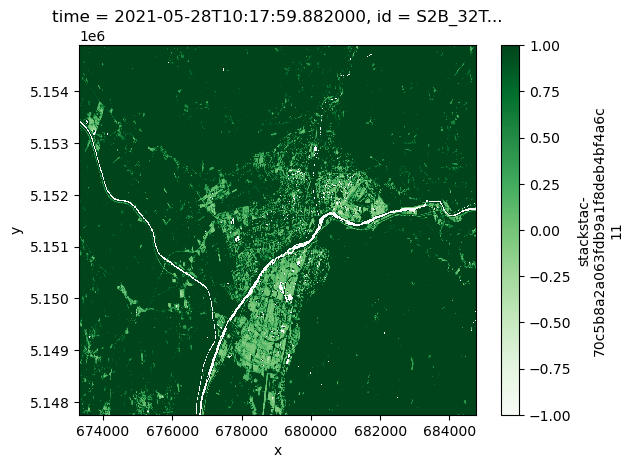

In [6]:
%%time
ndvi_xr[0].plot.imshow(vmin=-1,vmax=1,cmap="Greens")

Additionally, it is possible to reduce both spatial dimensions of the datacube at the same time.

To do this, we need the `reduce_spatial` process.

This time we select a smaller area of interest, to reduce the amount of downloaded data:

In [7]:
url = "https://earth-search.aws.element84.com/v1/collections/sentinel-2-l2a"
spatial_extent = {"west": 11.31369, "east": 11.31906, "south": 46.52167, "north": 46.52425}
temporal_extent = ["2021-01-01T00:00:00Z","2021-12-30T00:00:00Z"]
bands = ["red","nir"]
properties = {"eo:cloud_cover": dict(lt=15)}

datacube = local_conn.load_stac(url=url,
                                spatial_extent=spatial_extent,
                                temporal_extent=temporal_extent,
                                bands=bands,
                                properties=properties)
datacube = datacube.apply(lambda x: clip(x,0,10000)) # Get rid of possible negative values

In [8]:
datacube_spatial_median = datacube.reduce_spatial(reducer="median")
datacube_spatial_median

Verify that the spatial dimensions were collapsed:

In [9]:
datacube_spatial_median.execute()

<xarray.DataArray 'stackstac-5d5dd7e19c28f514c56d01ac702cc535' (time: 65,
                                                                band: 2)> Size: 1kB
dask.array<nanmedian, shape=(65, 2), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates: (12/51)
  * time                                     (time) datetime64[ns] 520B 2021-...
    id                                       (time) <U24 6kB 'S2B_32TPS_20210...
  * band                                     (band) <U3 24B 'red' 'nir'
    s2:medium_proba_clouds_percentage        (time) float64 520B 0.3084 ... 6...
    mgrs:grid_square                         <U2 8B 'PS'
    created                                  (time) <U24 6kB '2023-08-30T09:5...
    ...                                       ...
    proj:shape                               object 8B {10980}
    title                                    (band) <U20 160B 'Red (band 4) -...
    common_name                              (band) <U3 24B 'red' 'nir'
    center_wavelength                        (band) float64 16B 0.665 0.842
    full_width_half_max                      (band) float64 16B 0.038 0.145
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5090220.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5200020.00|\n| 0.0...
    resolution:  10.0

**Quiz hint: look carefully at the dimensions of the resulting datacube!**

We can combine this spatial reducer with the previous over bands to compute a time series of NDVI values:

In [10]:
ndvi_spatial = datacube_spatial_median.reduce_dimension(reducer=NDVI,dimension="band")

In [11]:
ndvi_spatial_xr = ndvi_spatial.execute()
ndvi_spatial_xr = ndvi_spatial_xr.compute()
ndvi_spatial_xr

<xarray.DataArray 'stackstac-5d5dd7e19c28f514c56d01ac702cc535' (time: 65)> Size: 520B
array([1.        , 1.        , 0.71978984, 1.        , 0.69875931,
       1.        , 0.55106523, 1.        , 0.61922538, 0.63405981,
       1.        , 0.69771529, 1.        , 0.69577791, 1.        ,
       0.70463079, 1.        , 0.71304819, 0.63879599, 1.        ,
       0.66345666, 1.        , 0.66151652, 0.77059345, 1.        ,
       0.70285714, 0.81495666, 1.        , 0.80841287, 0.83197631,
       0.8162926 , 0.82283105, 0.84370478, 1.        , 0.83643123,
       0.81262327, 1.        , 0.8294283 , 1.        , 0.84391259,
       1.        , 0.82469734, 1.        , 0.84010088, 1.        ,
       0.82158699, 1.        , 0.70340841, 1.        , 0.82460011,
       0.77229416, 0.80659341, 1.        , 0.80782918, 0.76727702,
       0.72676232, 0.7762406 , 1.        , 0.99874765, 0.8629386 ,
       0.82262211, 1.        , 1.        , 0.78430796, 0.78191985])
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 520B 2021-...
    id                                       (time) <U24 6kB 'S2B_32TPS_20210...
    s2:medium_proba_clouds_percentage        (time) float64 520B 0.3084 ... 6...
    mgrs:grid_square                         <U2 8B 'PS'
    created                                  (time) <U24 6kB '2023-08-30T09:5...
    view:sun_elevation                       (time) float64 520B 20.66 ... 19.33
    ...                                       ...
    constellation                            <U10 40B 'sentinel-2'
    mgrs:utm_zone                            int64 8B 32
    proj:transform                           object 8B {0, 600000, 10, 520002...
    gsd                                      int64 8B 10
    proj:shape                               object 8B {10980}
    epsg                                     int64 8B 32632
Attributes:
    spec:                           RasterSpec(epsg=32632, bounds=(600000.0, ...
    crs:                            epsg:32632
    transform:                      | 10.00, 0.00, 600000.00|\n| 0.00,-10.00,...
    resolution:                     10.0
    reduced_dimensions_min_values:  {'band': 0}

Remember that calling `.compute()` on an xarray + dask based object will load into memory the data.
In this case it will trigger the download of the data from the STAC Catalog and the processing defined as openEO process graph, computing the NDVI time series.

Visualize the NDVI time series:

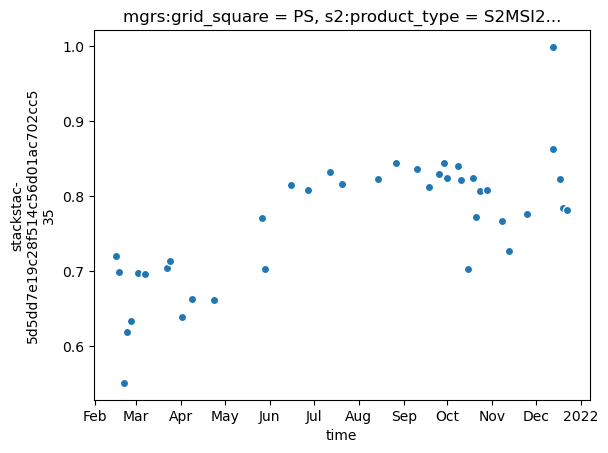

In [12]:
ndvi_spatial_xr.where(ndvi_spatial_xr<1).plot.scatter()